#**Load and Preprocess the MNIST Dataset**

Firstly, we will **normalize** the pixel values to [-1, 1] for stable GAN training. This is done because the Generator uses **tanh** activation at the output.

Then, we will **batch** the dataset to train on small chunks of data at a time.

In [ ]:
import torch
import torchvision
from torchvision.transforms import transforms

transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5))])

mnist =torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
batch_size=64
dataloader=torch.utils.data.DataLoader(mnist,batch_size=batch_size, shuffle=True)

images, labels=next(iter(dataloader))
print(f"Image batch shape: {images.shape}")
print(f"Label batch shape: {labels.shape}")

Image batch shape: torch.Size([64, 1, 28, 28])
Label batch shape: torch.Size([64])


# **Define the Generator**

We will define a generator that converts random noise (latent vector) into realistic images.

**ReLU** activations for hidden layers and **tanh** for output.

In [ ]:
import torch

class Generator(torch.nn.Module):
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(z_dim, 256),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(256),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(512),
            torch.nn.Linear(512, 1024),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(1024),
            torch.nn.Linear(1024, 28 * 28),
            torch.nn.Tanh()
        )

    def forward(self, x):
        return self.model(x).view(-1, 1, 28, 28)


# **Define the Discriminator**

We will define a discriminator that distinguishes between real and fake images.
Summary of the below code:

1. **LeakyReLU** to avoid vanishing gradients.
2. Dropout for regularization.
3. Sigmoid activation for binary classification.


In [ ]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 1024),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(1024, 512),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(512, 256),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(256, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x.view(-1, 28 * 28))


# **Implement the GAN Training Loop**

We will train the Discriminator on real and fake images and train the Generator to produce realistic images that fool the Discriminator.

For this, we will use **Binary Cross-Entropy Loss (BCE)** as the loss function and **Adam** as optimizer for both models.

In [ ]:
# Initialize models, loss function, and optimizers
z_dim = 100
G = Generator(z_dim)
D = Discriminator()

# Move models to device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G.to(device)
D.to(device)

# Loss function
criterion = torch.nn.BCELoss()

# Optimizers for both models
lr = 0.0002
optimizer_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# Number of epochs
epochs = 50
fixed_noise = torch.randn(64, z_dim, device=device)  # Fixed noise for visualization

# Training loop
for epoch in range(epochs):
    for real_images, _ in dataloader:
        real_images = real_images.to(device)

        # Labels for real and fake images
        real_labels = torch.ones(real_images.size(0), 1, device=device)
        fake_labels = torch.zeros(real_images.size(0), 1, device=device)

        # Train Discriminator
        # Real images
        outputs = D(real_images)
        d_loss_real = criterion(outputs, real_labels)

        # Fake images
        noise = torch.randn(real_images.size(0), z_dim, device=device)
        fake_images = G(noise)
        outputs = D(fake_images.detach())  # Detach fake images to not update G
        d_loss_fake = criterion(outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        outputs = D(fake_images)  # Fake images should be classified as real
        g_loss = criterion(outputs, real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    # Print losses after every epoch
    print(f"Epoch [{epoch+1}/{epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")

    # Visualize the Generator's output (fake images)
    if (epoch + 1) % 10 == 0:  # Every 10 epochs
        with torch.no_grad():
            fake_images = G(fixed_noise).detach().cpu()
            # Visualize images (you can add code here to plot the images)


Epoch [1/50], d_loss: 0.8042924404144287, g_loss: 1.1294758319854736
Epoch [2/50], d_loss: 1.3056962490081787, g_loss: 0.7471555471420288
Epoch [3/50], d_loss: 1.2494614124298096, g_loss: 0.8344384431838989
Epoch [4/50], d_loss: 1.2545664310455322, g_loss: 0.8012547492980957
Epoch [5/50], d_loss: 1.2044215202331543, g_loss: 0.8568525910377502
Epoch [6/50], d_loss: 1.3257360458374023, g_loss: 0.7511895298957825
Epoch [7/50], d_loss: 1.3372290134429932, g_loss: 0.7298933863639832
Epoch [8/50], d_loss: 1.3699311017990112, g_loss: 0.8073449730873108
Epoch [9/50], d_loss: 1.3935627937316895, g_loss: 0.8225346803665161
Epoch [10/50], d_loss: 1.3669987916946411, g_loss: 0.6887427568435669
Epoch [11/50], d_loss: 1.3531091213226318, g_loss: 0.8001422882080078
Epoch [12/50], d_loss: 1.3767380714416504, g_loss: 0.6992993950843811
Epoch [13/50], d_loss: 1.3600554466247559, g_loss: 0.652510404586792
Epoch [14/50], d_loss: 1.405482530593872, g_loss: 0.6968250274658203
Epoch [15/50], d_loss: 1.380104

# **Visualize Generator Outputs**

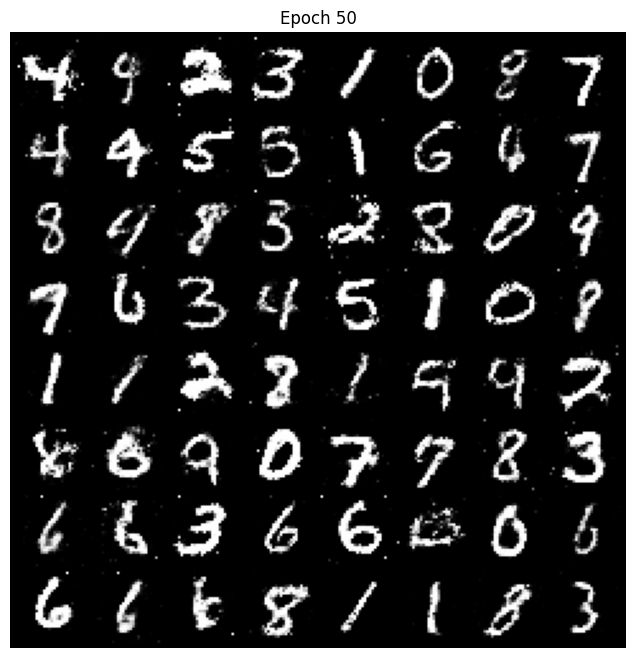

In [ ]:
import matplotlib.pyplot as plt

# Function to visualize generated images
def visualize_images(fake_images, epoch):
    grid = torchvision.utils.make_grid(fake_images, nrow=8, normalize=True)
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title(f'Epoch {epoch+1}')
    plt.axis('off')
    plt.show()

# Inside the training loop, call this function periodically (e.g., every 10 epochs)
if (epoch + 1) % 10 == 0:
    visualize_images(fake_images, epoch)

